# Pre trained model, Transfer Learning
https://jeinalog.tistory.com/13

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import torchvision
from torchvision import transforms, datasets, models, utils
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import shutil, os, glob, random
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

## 1. gpu 연결

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# gpu연산 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device} is available')
print("cuda number : ", os.environ["CUDA_VISIBLE_DEVICES"])
print("cuda device : ", torch.cuda.device_count())

cuda is available
cuda number :  1
cuda device :  1


## 2. data set 준비 

In [3]:
data_dir = './split/'

transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor(), # 차원을 (w, h, c) -> (c, w, h), array->tensor, min-max scale
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])
    
train_set = datasets.ImageFolder(data_dir + '/train', transform=transform)
val_set = datasets.ImageFolder(data_dir + '/val', transform=transform)
test_set = datasets.ImageFolder(data_dir + '/test', transform=transform)

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64


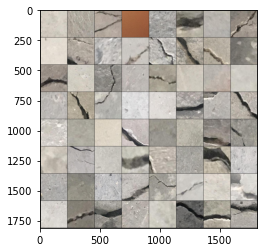

In [4]:
for data in val_dataloader:
    img, label = data
    plt.imshow(torchvision.utils.make_grid(img, normalize=True).permute(1,2,0))
    plt.show()
    break

## 3. call model

In [5]:
pre_model = models.resnet18(pretrained=True)

# output layer 수정
num_classes = 2
num_ftrs = pre_model.fc.in_features
pre_model.fc = nn.Linear(num_ftrs, num_classes)
model = pre_model.to(device)

# model summary
from torchsummary import summary
summary(model, input_size=(3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## 4. Model train, val

In [6]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    loss_train = []
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) 
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_train.append(loss.item())

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss_train

In [8]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    val_loss, correct = 0, 0
    loss_val2 = 0
    loss_val = []
    
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()
            loss_val2 = loss_fn(pred, y).item()
            loss_val.append(loss_val2)
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    val_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    
    return loss_val

In [ ]:
epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss_train = train(train_dataloader, model, criterion, optimizer)
    loss_val = val(val_dataloader, model, criterion)
print("Done!")

Epoch 1
-------------------------------
loss: 0.873020  [    0/32000]
loss: 0.081049  [ 6400/32000]
loss: 0.020041  [12800/32000]
loss: 0.077888  [19200/32000]
loss: 0.019619  [25600/32000]
Val Error: 
 Accuracy: 97.0%, Avg loss: 0.087762 

Epoch 2
-------------------------------
loss: 0.115545  [    0/32000]
loss: 0.121989  [ 6400/32000]
loss: 0.043928  [12800/32000]


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(loss_train, label='Training loss')

plt.figure(figsize=(20,5))
plt.plot(loss_val, label='Validation loss')

plt.figure(figsize=(20,5))
plt.plot(loss_train, label='Training loss')
plt.plot(loss_val, label='Validation loss')
plt.legend()
plt.show()

## 5. Save Model and Test

In [ ]:
torch.save(model, 'cnn_TL_model.pt')

In [ ]:
model = torch.load('./cnn_TL_model.pt')
model = model.to(device)

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
test(test_dataloader, model, criterion)